In [1]:
from Solvers import adv_solver, span_solver, span_solver2
from Adversary import Adversary, Problem
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k
from ElementDistinctness import ED
from copy import deepcopy as copy
import scipy
import cvxpy as cp
import itertools
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =100

In [2]:
class SpanProgram():
    def __init__(self, problem, I_dict):
        self.target = np.ones(problem.no_len)
        self.num_vects = np.sum([len(v) for i, v in I_dict.items()])
        self.ordered_I = [pair for pair in itertools.product(tuple(range(problem.n)), problem.alphabet)]
        self.I_to_mat = {}
        self.counter = 0
        self.vect_list = []
        self.ticks = []
        for pair, v_set in I_dict.items():
            self.ticks.append(self.counter)
            self.I_to_mat[pair] = list(range(self.counter, self.counter + len(v_set)))
            self.counter += len(v_set)
            self.vect_list.append(*v_set)
        
        self.A = np.block(self.vect_list).T 
    
    def get_activated_A(self, x):
        activated_A = np.zeros(self.A.shape)
        for i in range(len(x)):
            interval = self.I_to_mat[(i, x[i])]
            activated_A[:, interval] = self.A[:, interval]
        return activated_A
        
        
    def apply(x, witness):
        return get_activated_A(x) @ witness
    
    def visualize_A(self):
        plt.imshow(self.A)
        plt.xticks(self.ticks, self.ordered_I)
        plt.colorbar()
        plt.show()
            
        

In [3]:
def rand_function(n, alpha='01'):
    yes = []
    no = []
    for s in itertools.product(*[alpha]*n):
        if np.random.randint(2):
            yes.append(s)
        else:
            no.append(s)
    return Problem(no, yes)

In [4]:
prob = rand_function(4)
print(prob)
# 2.1753284295786104

No:[('0', '0', '0', '0'), ('0', '0', '0', '1'), ('0', '1', '0', '0'), ('1', '0', '0', '0'), ('1', '0', '1', '0'), ('1', '1', '1', '1')]
Yes:[('0', '0', '1', '0'), ('0', '0', '1', '1'), ('0', '1', '0', '1'), ('0', '1', '1', '0'), ('0', '1', '1', '1'), ('1', '0', '0', '1'), ('1', '0', '1', '1'), ('1', '1', '0', '0'), ('1', '1', '0', '1'), ('1', '1', '1', '0')]


0
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 10 06:44:52 PM: Your problem has 4097 variables, 79 constraints, and 0 parameters.
(CVXPY) Jul 10 06:44:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 06:44:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 06:44:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 06:44:52 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 10 06:44:52 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

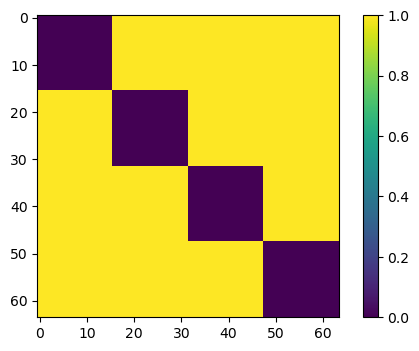

{'solver': 'MOSEK', 'verbose': True}
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 10 06:44:55 PM: Your problem has 4097 variables, 81 constraints, and 0 parameters.
(CVXPY) Jul 10 06:44:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 06:44:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 06:44:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 06:44:55 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 10 06:44:55 PM: Reduction chain: Dcp2Cone -

In [5]:
diffs = []
vals = []
for i in range(1):
    print(i)
    prob = rand_function(4)
    v, X = span_solver(prob)
    v2, X2 = span_solver2(prob)
    diffs.append(v - v2)
    vals.append((X, X2))
# X2 = np.round(X, 6)
# plt.imshow(X)
# plt.colorbar()

[-0.00029424609976747007]
(array([[ 1.05419685e+00,  1.05419225e+00, -1.03596396e-15, ...,
        -6.68865717e-16, -4.65502752e-16, -4.64538699e-16],
       [ 1.05419225e+00,  1.05420373e+00, -1.03650393e-15, ...,
        -6.68945660e-16, -4.65897523e-16, -4.64931615e-16],
       [-1.03596396e-15, -1.03650393e-15,  9.10294111e-01, ...,
        -4.67489171e-16,  2.49632624e-16,  2.52808167e-16],
       ...,
       [-6.68865717e-16, -6.68945660e-16, -4.67489171e-16, ...,
         7.35235313e-01,  6.14274511e-01,  6.14161277e-01],
       [-4.65502752e-16, -4.65897523e-16,  2.49632624e-16, ...,
         6.14274511e-01,  6.14259149e-01,  6.14244645e-01],
       [-4.64538699e-16, -4.64931615e-16,  2.52808167e-16, ...,
         6.14161277e-01,  6.14244645e-01,  6.14232851e-01]]), array([[1.05439129e+00, 1.05439086e+00, 4.23575029e-01, ...,
        9.88457447e-11, 9.89385078e-11, 9.88857483e-11],
       [1.05439086e+00, 1.05439212e+00, 4.23593236e-01, ...,
        9.86935097e-11, 9.87691367e-

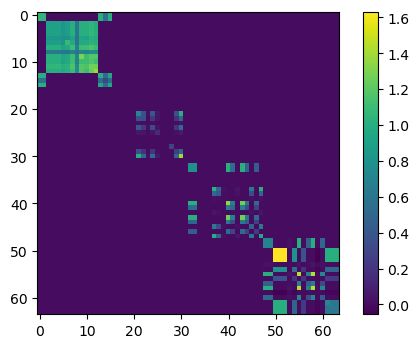

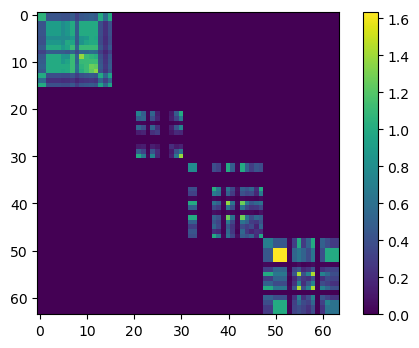

In [6]:
print(diffs)
for val in vals:
    print(val)
plt.imshow(vals[0][0])
plt.colorbar()
plt.show()
plt.imshow(vals[0][1])
plt.colorbar()
plt.show()

In [7]:
print(v, np.max([X[i][i] for i in range(X.shape[0])]))
print('norm', np.linalg.norm(X, 2))
print('len', X.shape[0])
print('rank', np.linalg.matrix_rank(X2), np.linalg.matrix_rank(X))
print(np.trace(X2))
# print(np.real_if_close(np.linalg.eigvals(X),4)[0])

2.5383511985992837 1.6280472774727246
norm 10.575319113157422
len 64
rank 64 64
40.33360738429352


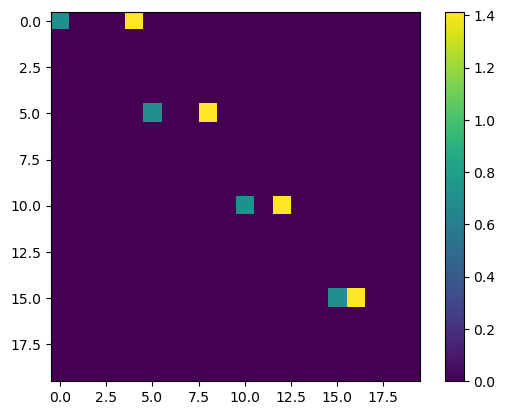

In [114]:
plt.imshow(L)
plt.colorbar()